# Variational autoencoders for collaborative filtering 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow==1.15

  Using cached https://files.pythonhosted.org/packages/ec/98/f968caf5f65759e78873b900cbf0ae20b1699fb11268ecc0f892186419a7/tensorflow-1.15.0-cp27-cp27mu-manylinux2010_x86_64.whl
     |████████████████████████████████| 3.8MB 8.3MB/s 
     |████████████████████████████████| 512kB 57.7MB/s 
  Found existing installation: tensorboard 2.1.0
    Uninstalling tensorboard-2.1.0:
      Successfully uninstalled tensorboard-2.1.0
  Found existing installation: tensorflow-estimator 1.15.0
    Uninstalling tensorflow-estimator-1.15.0:
      Successfully uninstalled tensorflow-estimator-1.15.0
  Found existing installation: tensorflow 2.1.0
    Uninstalling tensorflow-2.1.0:
      Successfully uninstalled tensorflow-2.1.0


In [ ]:
!pip install bottleneck

     |████████████████████████████████| 92kB 4.6MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for bottleneck: filename=Bottleneck-1.3.2-cp27-cp27mu-linux_x86_64.whl size=315070 sha256=4aa2639cdd49bc3eae2e9407645d6ba8ee450ba18993bcd070ec6891d95a6a5d
  Stored in directory: /root/.cache/pip/wheels/97/a9/12/41b13e8b44889ab05ec4dcc91f27da21634bacf2a0e87473b8
Successfully built bottleneck


In [ ]:
import os
import shutil
import sys

import numpy as np
from scipy import sparse

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sn
sn.set()

import pandas as pd

import tensorflow as tf
from tensorflow.contrib.layers import apply_regularization, l2_regularizer

import bottleneck as bn

## Data preprocessing

In [ ]:
DATA_DIR = '/content/drive/MyDrive/Project3/tmp/ml-1m'

In [ ]:
raw_data=pd.read_csv('/content/drive/MyDrive/Project3/tmp/ml-1m/ratings.dat',
                 sep='::',header=None)
raw_data=raw_data.rename(columns={0:'userId',1:'movieId',2:'rating',3:'timestamp'})

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [ ]:
# binarize the data (only keep ratings >= 4)
raw_data = raw_data[raw_data['rating'] > 3.5]

In [ ]:
raw_data.head()

,userId,movieId,rating,timestamp
0,1,1193,5,978300760
3,1,3408,4,978300275
4,1,2355,5,978824291
6,1,1287,5,978302039
7,1,2804,5,978300719


### Data splitting procedure

In [ ]:
def get_count(tp, id):
    playcount_groupbyid = tp[[id]].groupby(id, as_index=False)
    count = playcount_groupbyid.size()
    return count

In [ ]:
def filter_triplets(tp, min_uc=5, min_sc=0):
    # Only keep the triplets for items which were clicked on by at least min_sc users. 
    if min_sc > 0:
        itemcount = get_count(tp, 'movieId')
        tp = tp[tp['movieId'].isin(itemcount.index[itemcount >= min_sc])]
    
    # Only keep the triplets for users who clicked on at least min_uc items
    # After doing this, some of the items will have less than min_uc users, but should only be a small proportion
    if min_uc > 0:
        usercount = get_count(tp, 'userId')
        tp = tp[tp['userId'].isin(usercount.index[usercount >= min_uc])]
    
    # Update both usercount and itemcount after filtering
    usercount, itemcount = get_count(tp, 'userId'), get_count(tp, 'movieId') 
    return tp, usercount, itemcount

In [ ]:
raw_data, user_activity, item_popularity = filter_triplets(raw_data)

In [ ]:
sparsity = 1. * raw_data.shape[0] / (user_activity.shape[0] * item_popularity.shape[0])

print("After filtering, there are %d watching events from %d users and %d movies (sparsity: %.3f%%)" % 
      (raw_data.shape[0], user_activity.shape[0], item_popularity.shape[0], sparsity * 100))

After filtering, there are 575272 watching events from 6034 users and 3533 movies (sparsity: 2.699%)


In [ ]:
unique_uid = user_activity.index

np.random.seed(98765)
idx_perm = np.random.permutation(unique_uid.size)
unique_uid = unique_uid[idx_perm]

In [ ]:
# create train/validation/test users
n_users = unique_uid.size
n_heldout_users = 600

tr_users = unique_uid[:(n_users - n_heldout_users * 2)]
vd_users = unique_uid[(n_users - n_heldout_users * 2): (n_users - n_heldout_users)]
te_users = unique_uid[(n_users - n_heldout_users):]

In [ ]:
train_plays = raw_data.loc[raw_data['userId'].isin(tr_users)]

In [ ]:
unique_sid = pd.unique(train_plays['movieId'])

In [ ]:
show2id = dict((sid, i) for (i, sid) in enumerate(unique_sid))
profile2id = dict((pid, i) for (i, pid) in enumerate(unique_uid))

In [ ]:
pro_dir = os.path.join(DATA_DIR, 'pro_sg')

if not os.path.exists(pro_dir):
    os.makedirs(pro_dir)

with open(os.path.join(pro_dir, 'unique_sid.txt'), 'w') as f:
    for sid in unique_sid:
        f.write('%s\n' % sid)

In [ ]:
def split_train_test_proportion(data, test_prop=0.2):
    data_grouped_by_user = data.groupby('userId')
    tr_list, te_list = list(), list()

    np.random.seed(98765)

    for i, (_, group) in enumerate(data_grouped_by_user):
        n_items_u = len(group)

        if n_items_u >= 5:
            idx = np.zeros(n_items_u, dtype='bool')
            idx[np.random.choice(n_items_u, size=int(test_prop * n_items_u), replace=False).astype('int64')] = True

            tr_list.append(group[np.logical_not(idx)])
            te_list.append(group[idx])
        else:
            tr_list.append(group)

        if i % 1000 == 0:
            print("%d users sampled" % i)
            sys.stdout.flush()

    data_tr = pd.concat(tr_list)
    data_te = pd.concat(te_list)
    
    return data_tr, data_te

In [ ]:
vad_plays = raw_data.loc[raw_data['userId'].isin(vd_users)]
vad_plays = vad_plays.loc[vad_plays['movieId'].isin(unique_sid)]

In [ ]:
vad_plays_tr, vad_plays_te = split_train_test_proportion(vad_plays)

0 users sampled


In [ ]:
test_plays = raw_data.loc[raw_data['userId'].isin(te_users)]
test_plays = test_plays.loc[test_plays['movieId'].isin(unique_sid)]

In [ ]:
test_plays_tr, test_plays_te = split_train_test_proportion(test_plays)

0 users sampled


### Save the data into (user_index, item_index) format

In [ ]:
def numerize(tp):
    uid = map(lambda x: profile2id[x], tp['userId'])
    sid = map(lambda x: show2id[x], tp['movieId'])
    return pd.DataFrame(data={'uid': uid, 'sid': sid}, columns=['uid', 'sid'])

In [ ]:
train_data = numerize(train_plays)
train_data.to_csv(os.path.join(pro_dir, 'train.csv'), index=False)

In [ ]:
vad_data_tr = numerize(vad_plays_tr)
vad_data_tr.to_csv(os.path.join(pro_dir, 'validation_tr.csv'), index=False)

In [ ]:
vad_data_te = numerize(vad_plays_te)
vad_data_te.to_csv(os.path.join(pro_dir, 'validation_te.csv'), index=False)

In [ ]:
test_data_tr = numerize(test_plays_tr)
test_data_tr.to_csv(os.path.join(pro_dir, 'test_tr.csv'), index=False)

In [ ]:
test_data_te = numerize(test_plays_te)
test_data_te.to_csv(os.path.join(pro_dir, 'test_te.csv'), index=False)

In [ ]:
class MultiDAE(object):
    def __init__(self, p_dims, q_dims=None, lam=0.01, lr=1e-3, random_seed=None):
        self.p_dims = p_dims
        if q_dims is None:
            self.q_dims = p_dims[::-1]
        else:
            assert q_dims[0] == p_dims[-1], "Input and output dimension must equal each other for autoencoders."
            assert q_dims[-1] == p_dims[0], "Latent dimension for p- and q-network mismatches."
            self.q_dims = q_dims
        self.dims = self.q_dims + self.p_dims[1:]
        
        self.lam = lam
        self.lr = lr
        self.random_seed = random_seed

        self.construct_placeholders()

    def construct_placeholders(self):        
        self.input_ph = tf.placeholder(
            dtype=tf.float32, shape=[None, self.dims[0]])
        self.keep_prob_ph = tf.placeholder_with_default(1.0, shape=None)

    def build_graph(self):

        self.construct_weights()

        saver, logits = self.forward_pass()
        log_softmax_var = tf.nn.log_softmax(logits)

        # per-user average negative log-likelihood
        neg_ll = -tf.reduce_mean(tf.reduce_sum(
            log_softmax_var * self.input_ph, axis=1))
        # apply regularization to weights
        reg = l2_regularizer(self.lam)
        reg_var = apply_regularization(reg, self.weights)
        # tensorflow l2 regularization multiply 0.5 to the l2 norm
        # multiply 2 so that it is back in the same scale
        loss = neg_ll + 2 * reg_var
        
        train_op = tf.train.AdamOptimizer(self.lr).minimize(loss)

        # add summary statistics
        tf.summary.scalar('negative_multi_ll', neg_ll)
        tf.summary.scalar('loss', loss)
        merged = tf.summary.merge_all()
        return saver, logits, loss, train_op, merged

    def forward_pass(self):
        # construct forward graph        
        h = tf.nn.l2_normalize(self.input_ph, 1)
        h = tf.nn.dropout(h, self.keep_prob_ph)
        
        for i, (w, b) in enumerate(zip(self.weights, self.biases)):
            h = tf.matmul(h, w) + b
            
            if i != len(self.weights) - 1:
                h = tf.nn.tanh(h)
        return tf.train.Saver(), h

    def construct_weights(self):

        self.weights = []
        self.biases = []
        
        # define weights
        for i, (d_in, d_out) in enumerate(zip(self.dims[:-1], self.dims[1:])):
            weight_key = "weight_{}to{}".format(i, i+1)
            bias_key = "bias_{}".format(i+1)
            
            self.weights.append(tf.get_variable(
                name=weight_key, shape=[d_in, d_out],
                initializer=tf.contrib.layers.xavier_initializer(
                    seed=self.random_seed)))
            
            self.biases.append(tf.get_variable(
                name=bias_key, shape=[d_out],
                initializer=tf.truncated_normal_initializer(
                    stddev=0.001, seed=self.random_seed)))
            
            # add summary stats
            tf.summary.histogram(weight_key, self.weights[-1])
            tf.summary.histogram(bias_key, self.biases[-1])

In [ ]:
class MultiVAE(MultiDAE):

    def construct_placeholders(self):
        super(MultiVAE, self).construct_placeholders()

        # placeholders with default values when scoring
        self.is_training_ph = tf.placeholder_with_default(0., shape=None)
        self.anneal_ph = tf.placeholder_with_default(1., shape=None)
        
    def build_graph(self):
        self._construct_weights()

        saver, logits, KL = self.forward_pass()
        log_softmax_var = tf.nn.log_softmax(logits)

        neg_ll = -tf.reduce_mean(tf.reduce_sum(
            log_softmax_var * self.input_ph,
            axis=-1))
        # apply regularization to weights
        reg = l2_regularizer(self.lam)
        
        reg_var = apply_regularization(reg, self.weights_q + self.weights_p)
        # tensorflow l2 regularization multiply 0.5 to the l2 norm
        # multiply 2 so that it is back in the same scale
        neg_ELBO = neg_ll + self.anneal_ph * KL + 2 * reg_var
        
        train_op = tf.train.AdamOptimizer(self.lr).minimize(neg_ELBO)

        # add summary statistics
        tf.summary.scalar('negative_multi_ll', neg_ll)
        tf.summary.scalar('KL', KL)
        tf.summary.scalar('neg_ELBO_train', neg_ELBO)
        merged = tf.summary.merge_all()

        return saver, logits, neg_ELBO, train_op, merged
    
    def q_graph(self):
        mu_q, std_q, KL = None, None, None
        
        h = tf.nn.l2_normalize(self.input_ph, 1)
        h = tf.nn.dropout(h, self.keep_prob_ph)
        
        for i, (w, b) in enumerate(zip(self.weights_q, self.biases_q)):
            h = tf.matmul(h, w) + b
            
            if i != len(self.weights_q) - 1:
                h = tf.nn.tanh(h)
            else:
                mu_q = h[:, :self.q_dims[-1]]
                logvar_q = h[:, self.q_dims[-1]:]

                std_q = tf.exp(0.5 * logvar_q)
                KL = tf.reduce_mean(tf.reduce_sum(
                        0.5 * (-logvar_q + tf.exp(logvar_q) + mu_q**2 - 1), axis=1))
        return mu_q, std_q, KL

    def p_graph(self, z):
        h = z
        
        for i, (w, b) in enumerate(zip(self.weights_p, self.biases_p)):
            h = tf.matmul(h, w) + b
            
            if i != len(self.weights_p) - 1:
                h = tf.nn.tanh(h)
        return h

    def forward_pass(self):
        # q-network
        mu_q, std_q, KL = self.q_graph()
        epsilon = tf.random_normal(tf.shape(std_q))

        sampled_z = mu_q + self.is_training_ph *\
            epsilon * std_q

        # p-network
        logits = self.p_graph(sampled_z)
        
        return tf.train.Saver(), logits, KL

    def _construct_weights(self):
        self.weights_q, self.biases_q = [], []
        
        for i, (d_in, d_out) in enumerate(zip(self.q_dims[:-1], self.q_dims[1:])):
            if i == len(self.q_dims[:-1]) - 1:
                # we need two sets of parameters for mean and variance,
                # respectively
                d_out *= 2
            weight_key = "weight_q_{}to{}".format(i, i+1)
            bias_key = "bias_q_{}".format(i+1)
            
            self.weights_q.append(tf.get_variable(
                name=weight_key, shape=[d_in, d_out],
                initializer=tf.contrib.layers.xavier_initializer(
                    seed=self.random_seed)))
            
            self.biases_q.append(tf.get_variable(
                name=bias_key, shape=[d_out],
                initializer=tf.truncated_normal_initializer(
                    stddev=0.001, seed=self.random_seed)))
            
            # add summary stats
            tf.summary.histogram(weight_key, self.weights_q[-1])
            tf.summary.histogram(bias_key, self.biases_q[-1])
            
        self.weights_p, self.biases_p = [], []

        for i, (d_in, d_out) in enumerate(zip(self.p_dims[:-1], self.p_dims[1:])):
            weight_key = "weight_p_{}to{}".format(i, i+1)
            bias_key = "bias_p_{}".format(i+1)
            self.weights_p.append(tf.get_variable(
                name=weight_key, shape=[d_in, d_out],
                initializer=tf.contrib.layers.xavier_initializer(
                    seed=self.random_seed)))
            
            self.biases_p.append(tf.get_variable(
                name=bias_key, shape=[d_out],
                initializer=tf.truncated_normal_initializer(
                    stddev=0.001, seed=self.random_seed)))
            
            # add summary stats
            tf.summary.histogram(weight_key, self.weights_p[-1])
            tf.summary.histogram(bias_key, self.biases_p[-1])

In [ ]:
unique_sid = list()
with open(os.path.join(pro_dir, 'unique_sid.txt'), 'r') as f:
    for line in f:
        unique_sid.append(line.strip())

n_items = len(unique_sid)

In [ ]:
def load_train_data(csv_file):
    tp = pd.read_csv(csv_file)
    n_users = tp['uid'].max() + 1

    rows, cols = tp['uid'], tp['sid']
    data = sparse.csr_matrix((np.ones_like(rows),
                             (rows, cols)), dtype='float64',
                             shape=(n_users, n_items))
    return data

In [ ]:
train_data = load_train_data(os.path.join(pro_dir, 'train.csv'))

In [ ]:
def load_tr_te_data(csv_file_tr, csv_file_te):
    tp_tr = pd.read_csv(csv_file_tr)
    tp_te = pd.read_csv(csv_file_te)

    start_idx = min(tp_tr['uid'].min(), tp_te['uid'].min())
    end_idx = max(tp_tr['uid'].max(), tp_te['uid'].max())

    rows_tr, cols_tr = tp_tr['uid'] - start_idx, tp_tr['sid']
    rows_te, cols_te = tp_te['uid'] - start_idx, tp_te['sid']

    data_tr = sparse.csr_matrix((np.ones_like(rows_tr),
                             (rows_tr, cols_tr)), dtype='float64', shape=(end_idx - start_idx + 1, n_items))
    data_te = sparse.csr_matrix((np.ones_like(rows_te),
                             (rows_te, cols_te)), dtype='float64', shape=(end_idx - start_idx + 1, n_items))
    return data_tr, data_te

In [ ]:
vad_data_tr, vad_data_te = load_tr_te_data(os.path.join(pro_dir, 'validation_tr.csv'),
                                           os.path.join(pro_dir, 'validation_te.csv'))

Set up training hyperparameters

In [ ]:
N = train_data.shape[0]
idxlist = range(N)

# training batch size
batch_size = 500
batches_per_epoch = int(np.ceil(float(N) / batch_size))

N_vad = vad_data_tr.shape[0]
idxlist_vad = range(N_vad)

# validation batch size (since the entire validation set might not fit into GPU memory)
batch_size_vad = 2000

# the total number of gradient updates for annealing
total_anneal_steps = 200000
# largest annealing parameter
anneal_cap = 0.2

In [ ]:
def NDCG_binary_at_k_batch(X_pred, heldout_batch, k=100):
    '''
    normalized discounted cumulative gain@k for binary relevance
    ASSUMPTIONS: all the 0's in heldout_data indicate 0 relevance
    '''
    batch_users = X_pred.shape[0]
    idx_topk_part = bn.argpartition(-X_pred, k, axis=1)
    topk_part = X_pred[np.arange(batch_users)[:, np.newaxis],
                       idx_topk_part[:, :k]]
    idx_part = np.argsort(-topk_part, axis=1)
    # X_pred[np.arange(batch_users)[:, np.newaxis], idx_topk] is the sorted
    # topk predicted score
    idx_topk = idx_topk_part[np.arange(batch_users)[:, np.newaxis], idx_part]
    # build the discount template
    tp = 1. / np.log2(np.arange(2, k + 2))

    DCG = (heldout_batch[np.arange(batch_users)[:, np.newaxis],
                         idx_topk].toarray() * tp).sum(axis=1)
    IDCG = np.array([(tp[:min(n, k)]).sum()
                     for n in heldout_batch.getnnz(axis=1)])
    return DCG / IDCG

In [ ]:
def Recall_at_k_batch(X_pred, heldout_batch, k=100):
    batch_users = X_pred.shape[0]

    idx = bn.argpartition(-X_pred, k, axis=1)
    X_pred_binary = np.zeros_like(X_pred, dtype=bool)
    X_pred_binary[np.arange(batch_users)[:, np.newaxis], idx[:, :k]] = True

    X_true_binary = (heldout_batch > 0).toarray()
    tmp = (np.logical_and(X_true_binary, X_pred_binary).sum(axis=1)).astype(
        np.float32)
    recall = tmp / np.minimum(k, X_true_binary.sum(axis=1))
    return recall

In [ ]:
p_dims = [200, 600, n_items]

In [ ]:
tf.reset_default_graph()
vae = MultiVAE(p_dims, lam=0.0, random_seed=98765)

saver, logits_var, loss_var, train_op_var, merged_var = vae.build_graph()

ndcg_var = tf.Variable(0.0)
ndcg_dist_var = tf.placeholder(dtype=tf.float64, shape=None)
ndcg_summary = tf.summary.scalar('ndcg_at_k_validation', ndcg_var)
ndcg_dist_summary = tf.summary.histogram('ndcg_at_k_hist_validation', ndcg_dist_var)
merged_valid = tf.summary.merge([ndcg_summary, ndcg_dist_summary])

In [ ]:
arch_str = "I-%s-I" % ('-'.join([str(d) for d in vae.dims[1:-1]]))

In [ ]:
log_dir = '/volmount/log/ml-1m/VAE_anneal{}K_cap{:1.1E}/{}'.format(
    total_anneal_steps/1000, anneal_cap, arch_str)

if os.path.exists(log_dir):
    shutil.rmtree(log_dir)

print("log directory: %s" % log_dir)
summary_writer = tf.summary.FileWriter(log_dir, graph=tf.get_default_graph())

In [ ]:
chkpt_dir = '/volmount/chkpt/ml-1m/VAE_anneal{}K_cap{:1.1E}/{}'.format(
    total_anneal_steps/1000, anneal_cap, arch_str)

if not os.path.isdir(chkpt_dir):
    os.makedirs(chkpt_dir) 
    
print("chkpt directory: %s" % chkpt_dir)

In [ ]:
n_epochs = 200

In [ ]:
ndcgs_vad = []

with tf.Session() as sess:

    init = tf.global_variables_initializer()
    sess.run(init)

    best_ndcg = -np.inf

    update_count = 0.0
    
    for epoch in range(n_epochs):
        np.random.shuffle(idxlist)
        # train for one epoch
        for bnum, st_idx in enumerate(range(0, N, batch_size)):
            end_idx = min(st_idx + batch_size, N)
            X = train_data[idxlist[st_idx:end_idx]]
            
            if sparse.isspmatrix(X):
                X = X.toarray()
            X = X.astype('float32')           
            
            if total_anneal_steps > 0:
                anneal = min(anneal_cap, 1. * update_count / total_anneal_steps)
            else:
                anneal = anneal_cap
            
            feed_dict = {vae.input_ph: X, 
                         vae.keep_prob_ph: 0.5, 
                         vae.anneal_ph: anneal,
                         vae.is_training_ph: 1}        
            sess.run(train_op_var, feed_dict=feed_dict)

            if bnum % 100 == 0:
                summary_train = sess.run(merged_var, feed_dict=feed_dict)
                summary_writer.add_summary(summary_train, 
                                           global_step=epoch * batches_per_epoch + bnum) 
            
            update_count += 1
        
        # compute validation NDCG
        ndcg_dist = []
        for bnum, st_idx in enumerate(range(0, N_vad, batch_size_vad)):
            end_idx = min(st_idx + batch_size_vad, N_vad)
            X = vad_data_tr[idxlist_vad[st_idx:end_idx]]

            if sparse.isspmatrix(X):
                X = X.toarray()
            X = X.astype('float32')
        
            pred_val = sess.run(logits_var, feed_dict={vae.input_ph: X} )
            # exclude examples from training and validation (if any)
            pred_val[X.nonzero()] = -np.inf
            tmp=Recall_at_k_batch(pred_val, vad_data_te[idxlist_vad[st_idx:end_idx]],k=50)
            ndcg_dist.append(tmp)
        
        ndcg_dist = np.concatenate(ndcg_dist)
        ndcg_ = ndcg_dist.mean()
        print(ndcg_)
        ndcgs_vad.append(ndcg_)
        merged_valid_val = sess.run(merged_valid, feed_dict={ndcg_var: ndcg_, ndcg_dist_var: ndcg_dist})
        summary_writer.add_summary(merged_valid_val, epoch)

        # update the best model (if necessary)
        if ndcg_ > best_ndcg:
            saver.save(sess, '{}/model'.format(chkpt_dir))
            best_ndcg = ndcg_

0.19448218117080246
0.23662979434625706
0.24893671934499528
0.2560777042626859
0.2763526692862462
0.28975263271590845
0.3053958087403737
0.321162342166728
0.3332677959967896
0.34158827411405135
0.34976756167517037
0.3575980565576252
0.3664258813776077
0.3794476734839209
0.3904673787675955
0.3968355356489925
0.3940595441467998
0.39961652924592284
0.40937787975078144
0.4128279514056143
0.4113129798990691
0.41531804998783123
0.41344426403858725
0.4174802292639299
0.4199931451082689
0.42174767522297996
0.4262609808358952
0.42647672604483133
0.4270167953519842
0.4270488366748443
0.4264392792303735
0.4277036560417862
0.4332985564932794
0.43441689864807076
0.43413909537978174
0.43870456551627435
0.43522295044244574
0.44096823868270424
0.4381226176085145
0.4412884110616623
0.4439391679823304
0.4398048255324044
0.44311865419185875
0.44315304089147334
0.4444444695596067
0.4446134586020105
0.4473187059769884
0.44767471918116836
0.44273267069643435
0.4487648723153607
0.4455833982677335
0.446879199

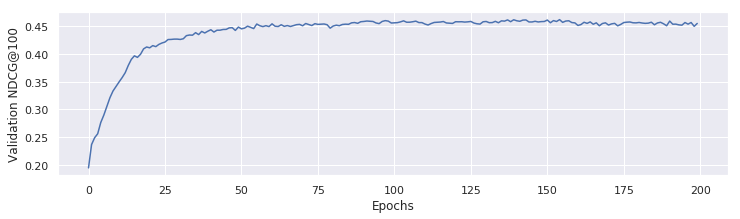

In [ ]:
plt.figure(figsize=(12, 3))
plt.plot(ndcgs_vad)
plt.ylabel("Validation NDCG@100")
plt.xlabel("Epochs")
pass

### Load the test data and compute test metrics

In [ ]:
test_data_tr, test_data_te = load_tr_te_data(
    os.path.join(pro_dir, 'test_tr.csv'),
    os.path.join(pro_dir, 'test_te.csv'))

In [ ]:
N_test = test_data_tr.shape[0]
idxlist_test = range(N_test)

batch_size_test = 2000

In [ ]:
tf.reset_default_graph()
vae = MultiVAE(p_dims, lam=0.0)
saver, logits_var, _, _, _ = vae.build_graph()    

INFO:tensorflow:Scale of 0 disables regularizer.
